# TC-CLIP Inference Demo for Custom Videos

In [ ]:
SETUP STUFF (RUN ONLY ONCE)

In [29]:
# Check NVIDIA driver
!nvidia-smi

Tue Mar  4 13:49:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.35                 Driver Version: 556.35         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro P2000                 WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   54C    P8             N/A / ERR!  |    2528MiB /   4096MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [32]:
# Get correct version of torch
!pip uninstall torch torchvision torchaudio -y 
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp312-cp312-win_amd64.whl (2449.3 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp312-cp312-win_amd64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp312-cp312-win_amd64.whl (4.1 MB)


In [33]:
# Verify torch installation

import torch
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("cuDNN Version:", torch.backends.cudnn.version())
print("Torch Version:", torch.__version__)

print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should return a positive number
print(torch.cuda.get_device_name(0))  # Should print your GPU model

CUDA Available: True
CUDA Version: 12.1
cuDNN Version: 90100
Torch Version: 2.5.1+cu121
True
1
Quadro P2000


Verify Cuda installed, make sure to restart notebook if the code below doesn't work!

In [40]:
!rustc --version

rustc 1.85.0 (4d91de4e4 2025-02-17)


In [ ]:
!pip install timm

If the command above doesnt work, you need to install rust https://www.rust-lang.org/tools/install.  
Download rustup-init.exe (64-bit) + run exe  
Restart Jupyter, run command below to check versions.  
Try installing `timm` again!

In [42]:
!rustc --version
!cargo --version

rustc 1.85.0 (4d91de4e4 2025-02-17)
cargo 1.85.0 (d73d2caf9 2024-12-31)


In [ ]:
# Install requirements
!pip install hydra-core
!pip install omegaconf
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu118/torch2.0/index.html
!pip install einops
!pip install ftfy
!pip install termcolor
!pip install decord

## Set model path, custom video path, class names. (Run every time below)

In [272]:
### Change to your settings ###
output="C:/Users/anaba/OneDrive/Desktop/Master Thesis/bias-action-recognition/framework/models/tc-clip/weights/inference"
tc_clip_model_path = "C:/Users/anaba/OneDrive/Desktop/Master Thesis/bias-action-recognition/framework/models/tc-clip/weights/zero_shot_k400_tc_clip.pth"   # Your pretrained model saved path
class_names = ['dancing', 'jumping', 'kicking', 'kneeling', 'punching', 'running', 'throwing', 'walking']  # Class names

parent_folder="C:/Users/anaba/OneDrive/Desktop/Master Thesis/bias-action-recognition/bedlam/be_imagedata_download/categorized/"
video_path = parent_folder + "20221011_1_250_batch01hand_closeup_suburb_d_mp4/walking/seq_000001.mp4" # TODO: Update custom video path

## No need to change below codes, just run the cells.

In [275]:
# Import libraries
import os
from hydra import initialize, compose
from omegaconf import OmegaConf
from pathlib import Path
import torch

from datasets.pipeline import Compose
from trainers.build_trainer import returnCLIP
from utils.logger import create_logger
from utils.print_utils import colorstr
from utils.tools import load_checkpoint

### Init configs and logger

In [278]:
# Initialize Hydra configs
overrides = [
    f"output={output}",
    "eval=test",
    "trainer=tc_clip",
    f"resume={tc_clip_model_path}"
]

# Initialize Hydra with config path
with initialize(version_base=None, config_path="configs"):
    config = compose(config_name="zero_shot.yaml", overrides=overrides)

In [279]:
# Init settings
OmegaConf.set_struct(config, False)  # Needed to add fields at runtime below

# Define working dir
Path(config.output).mkdir(parents=True, exist_ok=True)

# Logger
logger = create_logger(output_dir=config.output, dist_rank=0, name=f"{config.trainer_name}")
logger.info(f"working dir: {config.output}")

# Whether to use pytorch or apex amp
major, minor = int(torch.__version__.split('.')[0]), int(torch.__version__.split('.')[1])
config.use_torch_amp = (major >= 2)

[03-04 13:59:51 TCCLIP](3979588942.py 9): INFO working dir: C:/Users/anaba/OneDrive/Desktop/Master Thesis/bias-action-recognition/framework/models/tc-clip/weights/inference


### Build model & load checkpoint

In [283]:
# Build model
model = returnCLIP(config, logger, class_names)
model.cuda()

[03-04 13:59:51 TCCLIP](build_trainer.py 56): INFO Loading CLIP (backbone: ViT-B/16)
Using spatial positional embedding
Weights not found for some missing keys:  ['visual.transformer.resblocks.1.attn.local_global_bias_table', 'visual.transformer.resblocks.2.attn.local_global_bias_table', 'visual.transformer.resblocks.3.attn.local_global_bias_table', 'visual.transformer.resblocks.4.attn.local_global_bias_table', 'visual.transformer.resblocks.5.attn.local_global_bias_table', 'visual.transformer.resblocks.6.attn.local_global_bias_table', 'visual.transformer.resblocks.7.attn.local_global_bias_table', 'visual.transformer.resblocks.8.attn.local_global_bias_table', 'visual.transformer.resblocks.9.attn.local_global_bias_table', 'visual.transformer.resblocks.10.attn.local_global_bias_table', 'visual.transformer.resblocks.11.attn.local_global_bias_table']
[03-04 13:59:55 TCCLIP](build_trainer.py 59): INFO Building TCCLIP
[03-04 13:59:55 TCCLIP](tc_clip_prompt_learner.py 54): INFO Video-condition

TCCLIP(
  (prompt_learner): VPPromptLearner()
  (image_encoder): TCVisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): TCAttentionBlock(
          (attn): TCAttention(
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,

In [284]:
# Load checkpoint
if config.resume:
    epoch_loaded, max_accuray_loaded = load_checkpoint(config, model, None, None, logger, model_only=True)
    logger.info(
            f"Loaded checkpoint at epoch {epoch_loaded} with max accuracy {max_accuray_loaded:.1f}")

[03-04 13:59:56 TCCLIP](tools.py 180): INFO ==============> Resuming from C:/Users/anaba/OneDrive/Desktop/Master Thesis/bias-action-recognition/framework/models/tc-clip/weights/zero_shot_k400_tc_clip.pth....................
[03-04 13:59:56 TCCLIP](tools.py 208): INFO resume model: _IncompatibleKeys(missing_keys=['prompt_learner.token_prefix', 'prompt_learner.token_suffix'], unexpected_keys=[])
[03-04 13:59:56 TCCLIP](tools.py 218): INFO => loaded successfully 'C:/Users/anaba/OneDrive/Desktop/Master Thesis/bias-action-recognition/framework/models/tc-clip/weights/zero_shot_k400_tc_clip.pth' (epoch 9)
[03-04 13:59:56 TCCLIP](1028797808.py 4): INFO Loaded checkpoint at epoch 10 with max accuracy 81.3


### Video preprocessing pipeline

In [286]:
# Video preprocessing pipeline

img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_bgr=False)

scale_resize = int(256 / 224 * config.input_size)
collect_keys = ['imgs']

val_pipeline = [
    dict(type='DecordInit'),
    dict(type='SampleFrames', clip_len=1, frame_interval=1, num_clips=config.num_frames, test_mode=True),
    dict(type='DecordDecode'),
    dict(type='Resize', scale=(-1, scale_resize)),
    dict(type='CenterCrop', crop_size=config.input_size),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='FormatShape', input_format='NCHW'),
    dict(type='Collect', keys=collect_keys, meta_keys=[]),
    dict(type='ToTensor', keys=['imgs'])
]
if config.num_crop == 3:
    val_pipeline[3] = dict(type='Resize', scale=(-1, config.input_size))
    val_pipeline[4] = dict(type='ThreeCrop', crop_size=config.input_size)
if config.num_clip > 1:
    val_pipeline[1] = dict(type='SampleFrames', clip_len=1, frame_interval=1, num_clips=config.num_frames,
                           multiview=config.num_clip)
val_pipeline = [p for p in val_pipeline if p is not None]

pipeline = Compose(val_pipeline)

dict_file = {'filename': video_path, 'tar': False, 'modality': 'RGB', 'start_index': 0}

### TC-CLIP inference

In [288]:
video = pipeline(dict_file)
video_tensor = video['imgs'].unsqueeze(0).cuda().float() # Size: [1, T, 3, H, W]

# Inference with TC-CLIP
with torch.no_grad():
    if config.use_torch_amp:
        with torch.cuda.amp.autocast():
            output = model(video_tensor)
    else:
        output = model(video_tensor)
    
    logits = output['logits']

pred_index = logits.argmax(-1)

C:\Users\anaba\AppData\Local\Temp\ipykernel_29076\164853365.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


In [289]:
print(f'Logits: {logits}')
print("For video: ", video_path)
print(f'Predicted action category is "{class_names[pred_index]}"')

Logits: tensor([[23.5469, 23.1562, 22.9062, 23.4531, 20.9688, 24.6094, 22.6875, 25.9844]],
       device='cuda:0', dtype=torch.float16)
For video:  C:/Users/anaba/OneDrive/Desktop/Master Thesis/bias-action-recognition/bedlam/be_imagedata_download/categorized/20221011_1_250_batch01hand_closeup_suburb_d_mp4/walk/seq_000011.mp4
Predicted action category is "walking"


Acknowledgements: [ViFi-CLIP's repository](https://github.com/muzairkhattak/ViFi-CLIP).

---
## Running on a folder
---

In [345]:
import os
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from hydra import initialize, compose
from omegaconf import OmegaConf
from datasets.pipeline import Compose
from trainers.build_trainer import returnCLIP
from utils.logger import create_logger
from utils.tools import load_checkpoint

def extract_ground_truth(video_path):
    """Extracts the ground truth action from the video file path."""
    parts = Path(video_path).parts
    for part in reversed(parts):
        if part in class_names:
            return part
    return None

# User-defined settings
output = "C:/Users/anaba/OneDrive/Desktop/Master Thesis/bias-action-recognition/framework/models/tc-clip/weights/inference"
tc_clip_model_path = "C:/Users/anaba/OneDrive/Desktop/Master Thesis/bias-action-recognition/framework/models/tc-clip/weights/zero_shot_k400_tc_clip.pth"
class_names = ['dancing', 'jumping', 'kicking', 'kneeling', 'punching', 'running', 'throwing', 'walking']
parent_folder = "C:/Users/anaba/OneDrive/Desktop/Master Thesis/bias-action-recognition/bedlam/be_imagedata_download/categorized/"

# Initialize Hydra configs
overrides = [
    f"output={output}",
    "eval=test",
    "trainer=tc_clip",
    f"resume={tc_clip_model_path}"
]

with initialize(version_base=None, config_path="configs"):
    config = compose(config_name="zero_shot.yaml", overrides=overrides)

OmegaConf.set_struct(config, False)
Path(config.output).mkdir(parents=True, exist_ok=True)

logger = create_logger(output_dir=config.output, dist_rank=0, name=f"{config.trainer_name}")
logger.info(f"working dir: {config.output}")

config.use_torch_amp = torch.__version__.startswith("2")

[03-05 15:55:28 TCCLIP](1196747461.py 44): INFO working dir: C:/Users/anaba/OneDrive/Desktop/Master Thesis/bias-action-recognition/framework/models/tc-clip/weights/inference


In [347]:
# Build model
model = returnCLIP(config, logger, class_names)
model.cuda()

# Load checkpoint
if config.resume:
    epoch_loaded, max_accuracy_loaded = load_checkpoint(config, model, None, None, logger, model_only=True)
    logger.info(f"Loaded checkpoint at epoch {epoch_loaded} with max accuracy {max_accuracy_loaded:.1f}")

# Video preprocessing pipeline
img_norm_cfg = dict(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_bgr=False)
scale_resize = int(256 / 224 * config.input_size)
collect_keys = ['imgs']

val_pipeline = [
    dict(type='DecordInit'),
    dict(type='SampleFrames', clip_len=1, frame_interval=1, num_clips=config.num_frames, test_mode=True),
    dict(type='DecordDecode'),
    dict(type='Resize', scale=(-1, scale_resize)),
    dict(type='CenterCrop', crop_size=config.input_size),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='FormatShape', input_format='NCHW'),
    dict(type='Collect', keys=collect_keys, meta_keys=[]),
    dict(type='ToTensor', keys=['imgs'])
]

pipeline = Compose(val_pipeline)

[03-05 15:55:29 TCCLIP](build_trainer.py 56): INFO Loading CLIP (backbone: ViT-B/16)
Using spatial positional embedding
Weights not found for some missing keys:  ['visual.transformer.resblocks.1.attn.local_global_bias_table', 'visual.transformer.resblocks.2.attn.local_global_bias_table', 'visual.transformer.resblocks.3.attn.local_global_bias_table', 'visual.transformer.resblocks.4.attn.local_global_bias_table', 'visual.transformer.resblocks.5.attn.local_global_bias_table', 'visual.transformer.resblocks.6.attn.local_global_bias_table', 'visual.transformer.resblocks.7.attn.local_global_bias_table', 'visual.transformer.resblocks.8.attn.local_global_bias_table', 'visual.transformer.resblocks.9.attn.local_global_bias_table', 'visual.transformer.resblocks.10.attn.local_global_bias_table', 'visual.transformer.resblocks.11.attn.local_global_bias_table']
[03-05 15:55:33 TCCLIP](build_trainer.py 59): INFO Building TCCLIP
[03-05 15:55:33 TCCLIP](tc_clip_prompt_learner.py 54): INFO Video-condition

C:\Users\anaba\OneDrive\Desktop\Master Thesis\bias-action-recognition\framework\models\tc-clip\utils\tools.py:181: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint =

[03-05 15:55:34 TCCLIP](tools.py 208): INFO resume model: _IncompatibleKeys(missing_keys=['prompt_learner.token_prefix', 'prompt_learner.token_suffix'], unexpected_keys=[])
[03-05 15:55:34 TCCLIP](tools.py 218): INFO => loaded successfully 'C:/Users/anaba/OneDrive/Desktop/Master Thesis/bias-action-recognition/framework/models/tc-clip/weights/zero_shot_k400_tc_clip.pth' (epoch 9)
[03-05 15:55:34 TCCLIP](890561573.py 8): INFO Loaded checkpoint at epoch 10 with max accuracy 81.3


In [348]:
# Process all videos in parent folder
correct_predictions = 0
total_videos = 0
ground_truths = []
predictions = []

for root, _, files in os.walk(parent_folder):
    for file in files:
        if file.endswith(".mp4"):
            video_path = os.path.join(root, file)
            ground_truth = extract_ground_truth(video_path)
            if not ground_truth:
                continue
            
            total_videos += 1
            dict_file = {'filename': video_path, 'tar': False, 'modality': 'RGB', 'start_index': 0}
            video = pipeline(dict_file)
            video_tensor = video['imgs'].unsqueeze(0).cuda().float()
            
            with torch.no_grad():
                if config.use_torch_amp:
                    with torch.cuda.amp.autocast():
                        output = model(video_tensor)
                else:
                    output = model(video_tensor)
                logits = output['logits']
            
            pred_index = logits.argmax(-1).item()
            predicted_label = class_names[pred_index]
            
            ground_truths.append(ground_truth)
            predictions.append(predicted_label)
            
            match = "✔ MATCH" if predicted_label == ground_truth else "✘ MISMATCH"
            if predicted_label == ground_truth:
                correct_predictions += 1
            
            print(f'Video: {video_path} | Ground Truth: {ground_truth} | Predicted: {predicted_label} | {match}')

C:\Users\anaba\AppData\Local\Temp\ipykernel_29076\2088387876.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Video: C:/Users/anaba/OneDrive/Desktop/Master Thesis/bias-action-recognition/bedlam/be_imagedata_download/categorized/20221011_1_250_batch01hand_closeup_suburb_a_mp4\dancing\seq_000001.mp4 | Ground Truth: dancing | Predicted: dancing | ✔ MATCH
Video: C:/Users/anaba/OneDrive/Desktop/Master Thesis/bias-action-recognition/bedlam/be_imagedata_download/categorized/20221011_1_250_batch01hand_closeup_suburb_a_mp4\dancing\seq_000005.mp4 | Ground Truth: dancing | Predicted: dancing | ✔ MATCH
Video: C:/Users/anaba/OneDrive/Desktop/Master Thesis/bias-action-recognition/bedlam/be_imagedata_download/categorized/20221011_1_250_batch01hand_closeup_suburb_a_mp4\dancing\seq_000040.mp4 | Ground Truth: dancing | Predicted: dancing | ✔ MATCH
Video: C:/Users/anaba/OneDrive/Desktop/Master Thesis/bias-action-recognition/bedlam/be_imagedata_download/categorized/20221011_1_250_batch01hand_closeup_suburb_a_mp4\dancing\seq_000042.mp4 | Ground Truth: dancing | Predicted: dancing | ✔ MATCH
Video: C:/Users/anaba/On

Overall Accuracy: 29.20% (33/113)


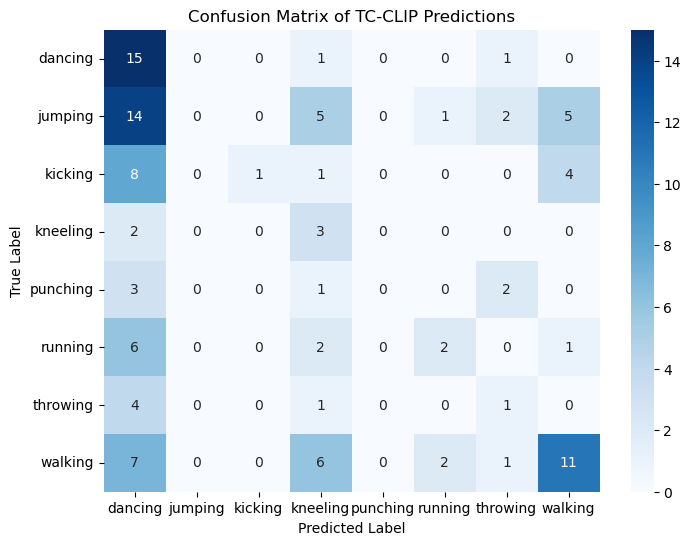

In [349]:
# Calculate and print overall accuracy
accuracy = (correct_predictions / total_videos) * 100 if total_videos > 0 else 0
print(f'Overall Accuracy: {accuracy:.2f}% ({correct_predictions}/{total_videos})')

# Generate confusion matrix
cm = confusion_matrix(ground_truths, predictions, labels=class_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of TC-CLIP Predictions")
plt.show()